In [111]:
from seaborn import color_palette
import numpy as np
import cv2
import os
import csv
import sys
import matplotlib.pyplot as plt
import tqdm
classes = ['articulated_truck', 'bicycle', 'bus', 'car',
           'motorcycle', 'motorized_vehicle', 'non-motorized_vehicle',
           'pedestrian', 'pickup_truck',
           'single_unit_truck', 'work_van']


def make_color_map(classes=classes):
    '''
        Create a color map for each class
    '''
    names = sorted(set(classes))
    n = len(names)

    if n == 0:
        return {}
    cp = color_palette("Paired", n)

    cp[:] = [tuple(int(255*c) for c in rgb) for rgb in cp]

    return dict(zip(names, cp))


def plot_bboxes(img, bboxes, color_map):
    '''
        Plot the  bounding boxes of a given image with a pre-defined colormap
    '''
    show_img = np.copy(img)

    fontFace = cv2.FONT_HERSHEY_SIMPLEX
    scale = 0.6
    thickness = 1

    for bbox in bboxes:
        label = bbox['class']
        pts = bbox['bbox']

        pt1 = (int(pts[0]), int(pts[1]))
        pt2 = (int(pts[2]), int(pts[3]))

        cv2.rectangle(show_img, pt1, pt2, color_map[label], 2)

        textSize, baseline = cv2.getTextSize(label, fontFace=fontFace,
                                             fontScale=scale,
                                             thickness=thickness)

        cv2.rectangle(show_img, pt1, (pt1[0]+textSize[0], pt1[1]+textSize[1]),
                      color_map[label])

        cv2.putText(show_img, label, (pt1[0], pt1[1]+baseline*2),
                    fontFace, scale, (255, 255, 255), thickness)

    return show_img

# train_label = {}
# with open('gt_train.csv', 'r') as f:
#     reader = csv.reader(f, delimiter=',')
#     for row in reader:
#         img_name = row[0]

#         bbox = {}
#         bbox['class'] = row[1]
#         if len(row) == 6:
#             bbox['bbox'] = np.array(row[2:]).astype('int32')
#         else:
#             bbox['score'] = float(row[2])
#             bbox['bbox'] = np.array(row[3:]).astype('int32')

#         if img_name in train_label:
#             train_label[img_name].append(bbox)
#         else:
#             train_label[img_name] = [bbox]

[{'class': 'car', 'bbox': array([571, 219, 662, 278], dtype=int32)}, {'class': 'motorized_vehicle', 'bbox': array([185,  85, 205, 112], dtype=int32)}]


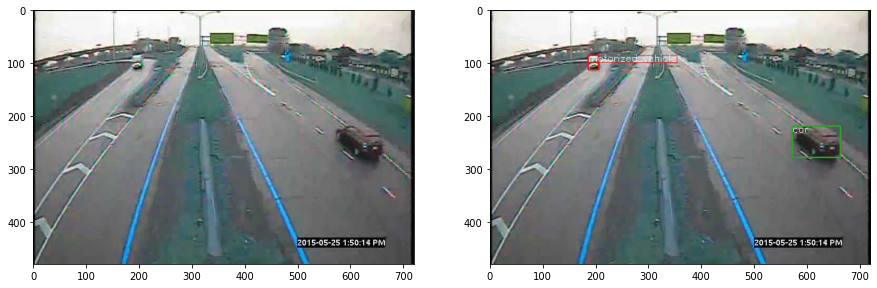

In [71]:
# color_map = make_color_map()

# # Plot the bounding box of the first 1000 images
# images = sorted(train_label.keys())
plt.figure(figsize=(15,15))
img_name = images[random.choice(range(1000))]
path = os.path.join('train', img_name+'.jpg')
bboxes = train_label[img_name]
img = cv2.imread(path)
if img is not None:
    print(bboxes)
    show_img = plot_bboxes(img, bboxes, color_map)

    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.subplot(1,2,2)
    plt.imshow(show_img)


In [61]:
import random
print(images[:10],'\n',random.choice(list(train_label.items())))

['00000000', '00000001', '00000002', '00000003', '00000004', '00000005', '00000006', '00000007', '00000008', '00000009'] 
 ('00029159', [{'class': 'motorized_vehicle', 'bbox': array([209,  42, 314,  87], dtype=int32)}])


In [74]:
def convert_xminymin_xcenterycenter(h, w, xmin, ymin, xmax, ymax):
    # < x_center > < y_center > < width > < height > - float values relative to width and height of image, it can  be  equal from (0.0 to 1.0]
    dw = 1. / (float(w))
    dh = 1. / (float(h))
    x = (xmin + xmax) / 2.0

    y = (ymin + ymax) / 2.0
    w = xmax - xmin
    h = ymax - ymin
    x = round(x * dw, 6)
    w = round(w * dw, 6)
    y = round(y * dh, 6)
    h = round(h * dh, 6)
    #     return x, y, w, h
    return f'{x} {y} {w} {h}'

In [93]:
thing_classes = ['car','truck','bus','motorcycle','bicycle','trains']
total_number_images=110000 #len(train_label.items())
convert_thing_dict={'articulated_truck':1,
 'bicycle':4,
 'bus':2,
 'car':0,
 'motorcycle':3,
 'motorized_vehicle':0,
 'non-motorized_vehicle':99,
 'pedestrian':98,
 'pickup_truck':1,
 'single_unit_truck':1,
 'work_van':1}
WORK_DIR='/home/yuanpu/vehicle/data'
LABEL_DIR='MIO-TCD-Localization/train'
IMAGE_FILE_TEMPLATE=os.path.join(WORK_DIR,LABEL_DIR)+'/{}.jpg'
ANN_FILE_TEMPLATE=os.path.join(WORK_DIR,LABEL_DIR) + '/{}.txt'
image_ids = sorted(train_label.keys())

In [94]:
#img.shape (480, 720, 3)

#000000 228, 342

for i in tqdm.tqdm(range(total_number_images)):
    anns=train_label[image_ids[i]]
    img=cv2.imread(IMAGE_FILE_TEMPLATE.format(image_ids[i]))
    h,w=img.shape[0],img.shape[1]
    with open(ANN_FILE_TEMPLATE.format(image_ids[i]),'w') as fid:
        for ann in anns:
            bbox=ann['bbox']
            a,b,c,d=bbox[0],bbox[1],bbox[2],bbox[3]
#             print(h,w,a,b,c,d)
            fid.write(f"{convert_thing_dict[ann['class']]} {convert_xminymin_xcenterycenter(h,w,a,b,c,d)}"+"\n")
#     break
    

100%|██████████| 110000/110000 [05:57<00:00, 307.77it/s]


In [109]:
def convert_back_xcenterycenter(ph, pw, x, y, w, h):
    x, y=float(x),float(y)
    dw, dh = float(pw) * float(w), float(ph) * float(h)
    xmin = round((x * pw) - (dw / 2), 6)
    xmax = round((x * pw) + (dw / 2), 6)
    ymin = round((y * ph) - (dh / 2), 6)
    ymax = round((y * ph) + (dh / 2), 6)
    return f"{xmin} {ymin} {xmax} {ymax}"

def plot_bboxes_xx(h,w,img, bboxesa, color_map):
    '''
        Plot the  bounding boxes of a given image with a pre-defined colormap
    '''
    show_img = np.copy(img)
    with open(bboxesa,'r') as fid:
        bboxeb=list(map(str.strip,fid.readlines()))
    bboxes=[]
    for i in bboxeb:
        a,b,c,d,e=i.split(' ')
        bboxes.append({
            'class':thing_classes[int(a)],
            'bbox':f"{convert_back_xcenterycenter(h,w,b,c,d,e)}"
        })
    fontFace = cv2.FONT_HERSHEY_SIMPLEX
    scale = 0.6
    thickness = 1

    for bbox in bboxes:
        label = bbox['class']
        pts = bbox['bbox'].split(' ')
        pts=list(map(float,pts))  
        pt1 = (int(pts[0]), int(pts[1]))
        pt2 = (int(pts[2]), int(pts[3]))

        cv2.rectangle(show_img, pt1, pt2, color_map[label], 2)

        textSize, baseline = cv2.getTextSize(label, fontFace=fontFace,
                                             fontScale=scale,
                                             thickness=thickness)

        cv2.rectangle(show_img, pt1, (pt1[0]+textSize[0], pt1[1]+textSize[1]),
                      color_map[label])

        cv2.putText(show_img, label, (pt1[0], pt1[1]+baseline*2),
                    fontFace, scale, (255, 255, 255), thickness)

    return show_img

train/00000922.txt


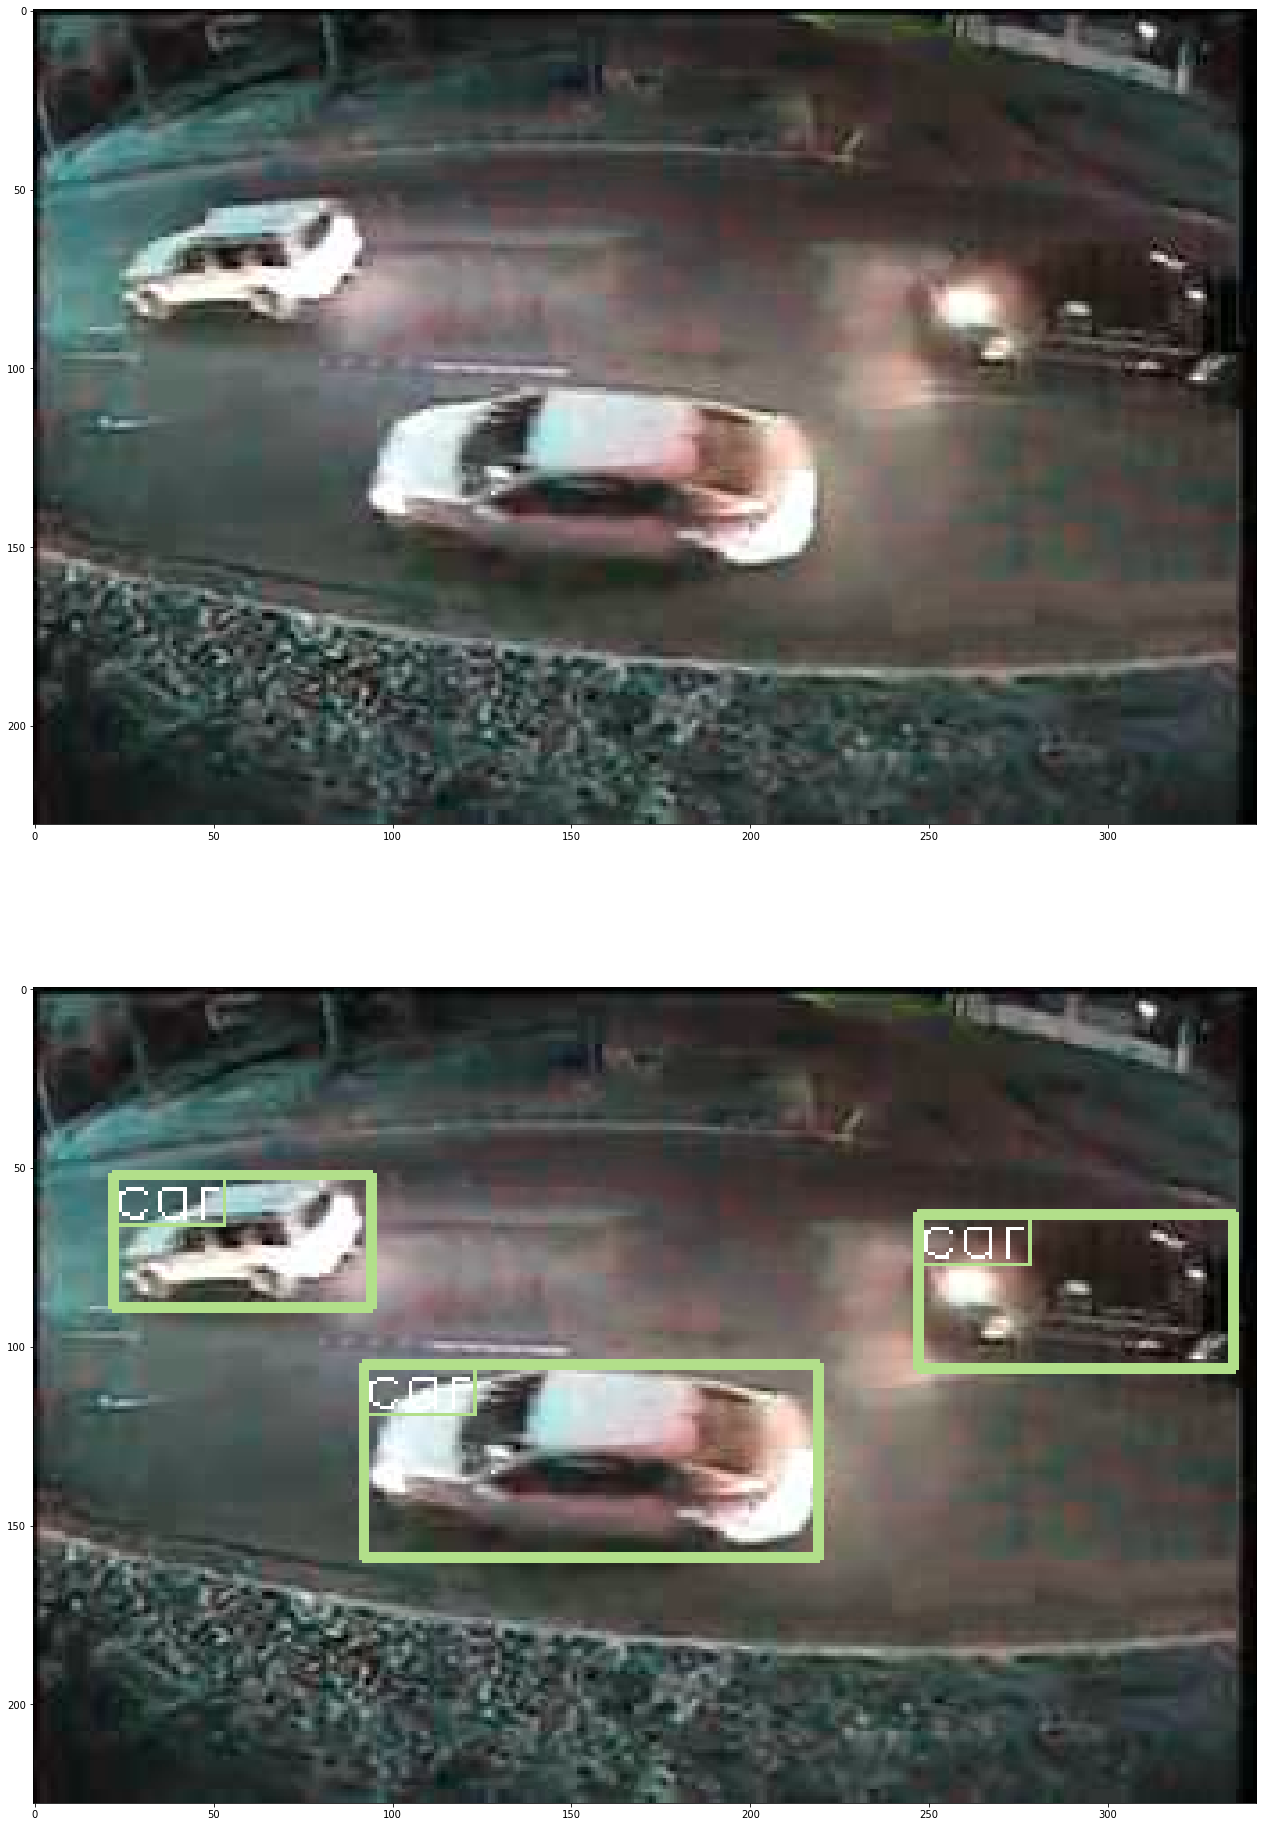

In [116]:
color_map = make_color_map(thing_classes)
plt.figure(figsize=(33,33))
img_name = image_ids[random.choice(range(1000))]
path = os.path.join('train', img_name+'.jpg')
# bboxes = train_label[img_name]
bboxes=os.path.join('train',img_name+'.txt')
img = cv2.imread(path)
if img is not None:
    print(bboxes)
    show_img = plot_bboxes_xx(img.shape[0],img.shape[1],img, bboxes, color_map)

    plt.subplot(2,1,1)
    plt.imshow(img)
    plt.subplot(2,1,2)
    plt.imshow(show_img)